- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [3]:
product_list = ["btc.usd.td", "eth.usd.td", "btc.usdt", "eth.usdt"]

In [4]:
period = 4096

In [5]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1148

1148

In [6]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [7]:
SAVE_PATH = "e:/intern"
all_dates_x = os.listdir(DATA_PATH + product_list[0])
all_dates_y = os.listdir(DATA_PATH + product_list[1])
all_dates = np.array(list(set(all_dates_x) & set(all_dates_y)))
all_dates.sort()
train_sample = all_dates<"2019-08"
test_sample = all_dates>"2019-08"
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
print(sum(train_sample))
print(sum(test_sample))
## 122
## 180

122
180


In [8]:
new_date = "2020-05-23"
out_sample = all_dates>=new_date
date_str = [n[0:10] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])
sum(out_sample)
## 88

88

In [9]:
def add_min_max(file, period_list):
    data = load(file)
    data = data.reset_index(drop=True)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    save(data, file)

In [10]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()

In [23]:
%%time
for product in product_list[0:2]:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    parLapply(CORE_NUM, file_list, add_min_max, period_list=[1024, 2048, 4096])## Wall time: 1min 35s


Wall time: 1min 12s


In [11]:
import dask
from dask import compute, delayed

In [12]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [13]:
SAVE_PATH = "e:/intern"

In [14]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        diff_bid_qty = data["bid.qty"] - data["bid.qty"].shift()
        diff_bid_qty[0] = 0
        diff_ask_qty = data["ask.qty"] - data["ask.qty"].shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period).values
    
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values
    
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True).values

class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).values

from collections import OrderedDict
class foctor_std_period(factor_template):
    factor_name = "std.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return np.sqrt(fast_roll_var(data["wpr"], period))


from collections import OrderedDict
class foctor_range_period(factor_template):
    factor_name = "range.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return data["max."+str(period)]-data["min."+str(period)]
    
from collections import OrderedDict
class foctor_volume_open_ratio_period(factor_template):
    factor_name = "volume.open.ratio.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(cum(data["qty"],period), cum(data["cum.open.int"]/period,period))

from collections import OrderedDict
class foctor_trend_index_period(factor_template):
    factor_name = "trend.index.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        aa = zero_divide(abs(data["wpr"]-data["wpr"].shift(period)), data["max."+str(period)]-data["min."+str(period)])
        aa[0:period]=0
        return aa

def get_atr(file, product, period_list, spread, SAVE_PATH="e:/intern"):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, SAVE_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-14:])

class foctor_atr_period(factor_template):
    factor_name = "atr.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        signal = (data["max."+str(period)]-data["min."+str(period)])
        return signal.values

- Now we generate all the signals one by one for the new data

In [15]:
x3 = foctor_nr_period()
x4 = foctor_dbook_period()
x5 = foctor_range_pos_period()
x6 = foctor_price_osci_period()
x7 = foctor_ma_diff_period()
x8 = foctor_kdj_j_period()
x9 = foctor_kdj_k_period()
x10 = foctor_range_period()
x11 = foctor_std_period()
x13 = foctor_trend_index_period()

In [16]:
new_dates = all_dates[all_dates>=new_date]
new_dates.sort()
len(new_dates)

88

In [17]:
import os
SAVE_PATH = "e:/intern"
for product in product_list[0:2]:
    os.makedirs(SAVE_PATH + "/tmp pkl/" + product, exist_ok=True)

In [35]:
all_signal_list = [x3, x4, x5, x6, x7, x8, x9, x10, x11,x13]
for product in product_list[0:2]:
    for xx in all_signal_list:
        create_signal_path(xx, product, SAVE_PATH)

e:/intern/tmp pkl/btc.usd.td/nr.1024
e:/intern/tmp pkl/btc.usd.td/nr.2048
e:/intern/tmp pkl/btc.usd.td/nr.4096
e:/intern/tmp pkl/btc.usd.td/dbook.1024
e:/intern/tmp pkl/btc.usd.td/dbook.2048
e:/intern/tmp pkl/btc.usd.td/dbook.4096
e:/intern/tmp pkl/btc.usd.td/range.pos.1024
e:/intern/tmp pkl/btc.usd.td/range.pos.2048
e:/intern/tmp pkl/btc.usd.td/range.pos.4096
e:/intern/tmp pkl/btc.usd.td/price.osci.1024
e:/intern/tmp pkl/btc.usd.td/price.osci.2048
e:/intern/tmp pkl/btc.usd.td/price.osci.4096
e:/intern/tmp pkl/btc.usd.td/ma.dif.10.1024
e:/intern/tmp pkl/btc.usd.td/ma.dif.10.2048
e:/intern/tmp pkl/btc.usd.td/ma.dif.10.4096
e:/intern/tmp pkl/btc.usd.td/kdj.j.1024
e:/intern/tmp pkl/btc.usd.td/kdj.j.2048
e:/intern/tmp pkl/btc.usd.td/kdj.j.4096
e:/intern/tmp pkl/btc.usd.td/kdj.k.1024
e:/intern/tmp pkl/btc.usd.td/kdj.k.2048
e:/intern/tmp pkl/btc.usd.td/kdj.k.4096
e:/intern/tmp pkl/btc.usd.td/range.1024
e:/intern/tmp pkl/btc.usd.td/range.2048
e:/intern/tmp pkl/btc.usd.td/range.4096
e:/intern/

In [36]:
%%time
i = 0
all_signal_list = [x3, x4, x5, x6, x7, x8, x9, x10, x11, x13]
for xx in all_signal_list:
    for product in product_list[0:2]:
        print("signal ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH,n=14)
    i = i + 1


signal  0 btc.usd.td
signal  0 eth.usd.td
signal  1 btc.usd.td
signal  1 eth.usd.td
signal  2 btc.usd.td
signal  2 eth.usd.td
signal  3 btc.usd.td
signal  3 eth.usd.td
signal  4 btc.usd.td
signal  4 eth.usd.td
signal  5 btc.usd.td
signal  5 eth.usd.td
signal  6 btc.usd.td
signal  6 eth.usd.td
signal  7 btc.usd.td
signal  7 eth.usd.td
signal  8 btc.usd.td
signal  8 eth.usd.td
signal  9 btc.usd.td
signal  9 eth.usd.td
Wall time: 7min 29s


In [37]:
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["range", "std", "trend.index"]
period_list = np.power(2, range(10,13))

In [41]:
def construct_composite_signal(dire_signal, range_signal, period_list, date_list, product_list, HEAD_PATH):
    from collections import OrderedDict
    class foctor_xx_period(factor_template):
        factor_name = dire_signal+"."+range_signal+".period"
        params = OrderedDict([
            ("period", period_list)
        ])
        def formula(self, data, period):
            return (data[dire_signal+"."+str(period)]*data[range_signal+"."+str(period)]).values
    xx = foctor_xx_period()
    for product in product_list:
        create_signal_path(xx, product, HEAD_PATH)
        file_list = [DATA_PATH+product+"/"+date for date in date_list]
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=HEAD_PATH, n=14)

In [42]:
%%time
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        construct_composite_signal(dire_signal, range_signal, period_list, new_dates, product_list[:2], SAVE_PATH)

## Wall time: 14min 15s

e:/intern/tmp pkl/btc.usd.td/nr.range.1024
e:/intern/tmp pkl/btc.usd.td/nr.range.2048
e:/intern/tmp pkl/btc.usd.td/nr.range.4096
e:/intern/tmp pkl/eth.usd.td/nr.range.1024
e:/intern/tmp pkl/eth.usd.td/nr.range.2048
e:/intern/tmp pkl/eth.usd.td/nr.range.4096
e:/intern/tmp pkl/btc.usd.td/dbook.range.1024
e:/intern/tmp pkl/btc.usd.td/dbook.range.2048
e:/intern/tmp pkl/btc.usd.td/dbook.range.4096
e:/intern/tmp pkl/eth.usd.td/dbook.range.1024
e:/intern/tmp pkl/eth.usd.td/dbook.range.2048
e:/intern/tmp pkl/eth.usd.td/dbook.range.4096
e:/intern/tmp pkl/btc.usd.td/range.pos.range.1024
e:/intern/tmp pkl/btc.usd.td/range.pos.range.2048
e:/intern/tmp pkl/btc.usd.td/range.pos.range.4096
e:/intern/tmp pkl/eth.usd.td/range.pos.range.1024
e:/intern/tmp pkl/eth.usd.td/range.pos.range.2048
e:/intern/tmp pkl/eth.usd.td/range.pos.range.4096
e:/intern/tmp pkl/btc.usd.td/price.osci.range.1024
e:/intern/tmp pkl/btc.usd.td/price.osci.range.2048
e:/intern/tmp pkl/btc.usd.td/price.osci.range.4096
e:/intern/tmp

In [72]:
%%time
for product in product_list[0:2]:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
    #parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=[4096], spread=spread) 
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13)), spread=spread) 


Wall time: 25.5 s


In [64]:
def count_daily_num(x, period):
    data = load(x)
    return np.floor(sum(data["good"])/period)

In [112]:
%%time
for product in product_list[0:2]:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    daily_num = pd.Series(parLapply(CORE_NUM, file_list, count_daily_num, period=period))
    save(daily_num, HEAD_PATH+"/daily num/"+product+".pkl")

#Wall time: 1min 8s


Wall time: 1min 8s


In [46]:
def get_signal_mat(signal_mat, signal_name, product, file_name, HEAD_PATH):
    S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file_name)
    S[np.isnan(S)] = 0
    if signal_mat is None:
        return S
    else:
        return np.vstack((signal_mat, S))


In [47]:
def par_get_signal_mat(file_name, product, signal_list, HEAD_PATH, SAVE_PATH):
    signal_mat = functools.reduce(functools.partial(get_signal_mat, product=product, file_name=file_name, HEAD_PATH=SAVE_PATH), signal_list, None)
    save(signal_mat, SAVE_PATH+"/signal mat pkl/"+product+"/"+file_name)

In [48]:
for product in product_list[:2]:
    os.makedirs(SAVE_PATH+"/signal mat pkl/"+product, exist_ok=True)

In [49]:
%%time
for product in product_list[:2]:
    print(product)
    parLapply(CORE_NUM, new_dates, par_get_signal_mat, 
              product=product, signal_list=signal_list, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# btc.usd.td
# eth.usd.td
# Wall time: 1min 17s


btc.usd.td
eth.usd.td
Wall time: 1min 17s


- we test several models:
- in-sample/out-sample lasso of week 9
- rolling lasso of week 9
- medium frequency lasso of week 11

In [55]:
import sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
#y_signal = "ret."+str(period)+".004"
y_signal = "ret."+str(period)

In [51]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-4]
signal_names
col_names = ori_mat.columns

In [53]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[signal_names]
#train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=signal_names)
train_mat.shape
## (4470, 28)

(4470, 28)

In [56]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = pd.DataFrame(data=sklearn.preprocessing.scale(train_mat, with_mean=False), columns=col_names)
print(product_list[0], train_mat.shape)
for product in product_list[1:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)
    
# btc.usd.td (4470, 32)
# eth.usd.td (3801, 32)


btc.usd.td (4470, 32)
eth.usd.td (3801, 32)


In [57]:
train_std_mat = dict([])
for product in product_list[:2]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_mat)

In [58]:
x_train = train_mat.iloc[:, :n_signal].values
#x_train = train_mat[result["chosen.signals"]]
#x_train = train_mat[signal_list[chosen_signals]]
y_train = train_mat.loc[:, y_signal].values
print(np.shape(x_train))
scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
scaler.fit(x_train)
x_std = np.sqrt(scaler.var_)
x_train_normal = scaler.transform(x_train)
model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
fit_coef = np.zeros(n_signal)
#fit_coef[pos] = model.coef_/x_std
fit_coef = model.coef_/x_std
print(fit_coef)
# (8271, 28)
# [ 0.0155054   0.00570079  0.02440753 -0.         -0.07424719  0.
#   0.          0.06562325 -0.00528303 -0.          0.          0.09833834
#   0.         -0.05236299  0.01675821  0.          0.16193953  0.
#  -0.          0.         -0.19170497 -0.         -0.         -0.
#  -0.          0.         -0.         -0.03495968]

(8271, 28)
[ 0.0155054   0.00570079  0.02440753 -0.         -0.07424719  0.
  0.          0.06562325 -0.00528303 -0.          0.          0.09833834
  0.         -0.05236299  0.01675821  0.          0.16193953  0.
 -0.          0.         -0.19170497 -0.         -0.         -0.
 -0.          0.         -0.         -0.03495968]


In [59]:
coef_list=dict([])
for product in product_list[:2]:
    coef = fit_coef*train_std_mat[product][y_signal]/train_std_mat[product][signal_names]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])
    
# btc.usd.td
# nr.4096                   0.001117
# dbook.4096                0.001771
# range.pos.4096            0.001346
# ma.dif.10.4096           -0.107693
# nr.range.4096             0.000097
# dbook.range.4096         -0.000022
# ma.dif.10.range.4096      0.000473
# kdj.j.range.4096         -0.000011
# nr.std.4096               0.000090
# range.pos.std.4096        0.000378
# kdj.j.std.4096           -0.000137
# kdj.j.trend.index.4096   -0.000941
# dtype: float64
# eth.usd.td
# nr.4096                   0.002321
# dbook.4096                0.003363
# range.pos.4096            0.002009
# ma.dif.10.4096           -0.068967
# nr.range.4096             0.002435
# dbook.range.4096         -0.000670
# ma.dif.10.range.4096      0.002446
# kdj.j.range.4096         -0.000247
# nr.std.4096               0.001970
# range.pos.std.4096        0.007456
# kdj.j.std.4096           -0.002631
# kdj.j.trend.index.4096   -0.001530
# dtype: float64

btc.usd.td
nr.4096                   0.001117
dbook.4096                0.001771
range.pos.4096            0.001346
ma.dif.10.4096           -0.107693
nr.range.4096             0.000097
dbook.range.4096         -0.000022
ma.dif.10.range.4096      0.000473
kdj.j.range.4096         -0.000011
nr.std.4096               0.000090
range.pos.std.4096        0.000378
kdj.j.std.4096           -0.000137
kdj.j.trend.index.4096   -0.000941
dtype: float64
eth.usd.td
nr.4096                   0.002321
dbook.4096                0.003363
range.pos.4096            0.002009
ma.dif.10.4096           -0.068967
nr.range.4096             0.002435
dbook.range.4096         -0.000670
ma.dif.10.range.4096      0.002446
kdj.j.range.4096         -0.000247
nr.std.4096               0.001970
range.pos.std.4096        0.007456
kdj.j.std.4096           -0.002631
kdj.j.trend.index.4096   -0.001530
dtype: float64


In [60]:
strat = "overall.crypto.lasso."+str(period)
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [61]:
%%time
for product in product_list[:2]:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, new_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
    
# btc.usd.td
# eth.usd.td
# Wall time: 31.5 s

btc.usd.td
eth.usd.td
Wall time: 31.5 s


In [62]:
def get_good(date, product, HEAD_PATH, SAVE_PATH):
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+date)
    good = data["good"]
    save(good, SAVE_PATH+"/good pkl/"+product+"/"+date)  

In [63]:
%%time
for product in product_list[:2]:
    parLapply(CORE_NUM, new_dates, get_good, product=product, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern")
    
#Wall time: 23.4 s

Wall time: 23.4 s


In [66]:
%%time
for product in product_list[:2]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")
    
# Wall time: 37.4 s

Wall time: 37.4 s


In [90]:
%%time
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("overall.crypto.lasso", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str="2019-08", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# Wall time: 9min 13s


reverse=1
reverse=1
Wall time: 9min 13s


btc.usd.td train sharpe  0.5844919836354413 test sharpe  0.4025139388330891
eth.usd.td train sharpe  1.499444144005969 test sharpe  1.3265176001057026
train sharpe:  1.411407339693374 test sharpe:  0.689464884469878


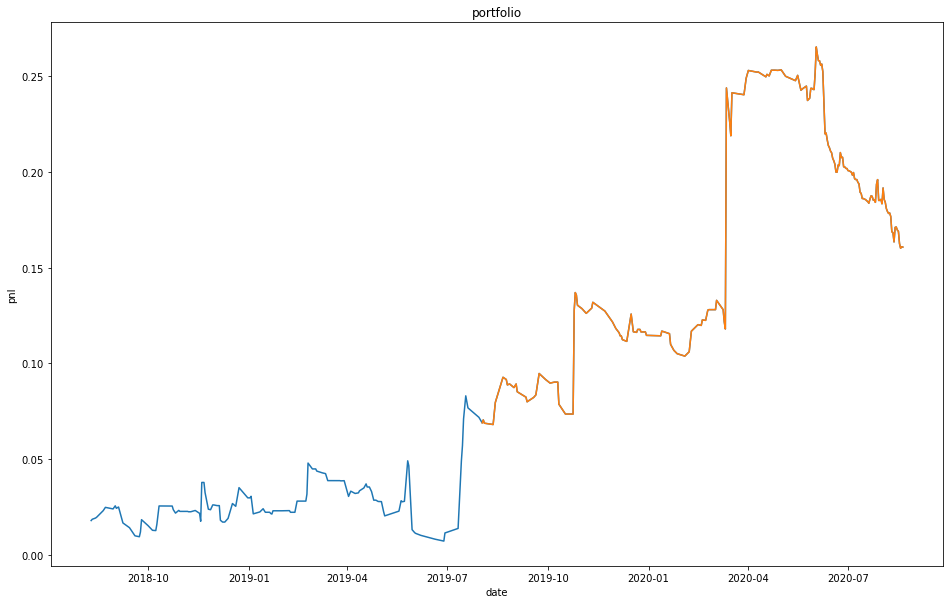

In [94]:
i = 0
strat = "overall.crypto.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list[:2]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# btc.usd.td train sharpe  0.5844919836354413 test sharpe  0.4025139388330891
# eth.usd.td train sharpe  1.499444144005969 test sharpe  1.3265176001057026
# train sharpe:  1.411407339693374 test sharpe:  0.689464884469878






- we can see that the out-sample portfolio is quite good
- now we go to the rolling lasso model

In [20]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [21]:
month = np.array([file[:7] for file in all_dates])
month_len = np.unique(month, return_counts=True)
month_len

# (array(['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
#         '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
#         '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
#         '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
#         '2020-08'], dtype='<U7'),
#  array([ 7, 10, 10, 14, 11, 11, 10, 12, 14, 10,  6,  7, 10,  8, 11,  6, 14,
#          6, 10, 11,  9, 14, 30, 31, 20], dtype=int64))

(array(['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
        '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
        '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
        '2020-08'], dtype='<U7'),
 array([ 7, 10, 10, 14, 11, 11, 10, 12, 14, 10,  6,  7, 10,  8, 11,  6, 14,
         6, 10, 11,  9, 14, 30, 31, 20], dtype=int64))

In [22]:
test_range = np.where(month_len[0] > "2019-08" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] <= "2019-08")-1
cum_month_len = np.cumsum(month_len[1])

# ['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
#  '2020-04' '2020-05' '2020-06' '2020-07' '2020-08']


['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
 '2020-04' '2020-05' '2020-06' '2020-07' '2020-08']


In [23]:
new_start = np.where(month_len[0]>="2020-05")[0][0]
new_start
## 21

21

In [24]:
month_len[0][test_range]

# array(['2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
#        '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'],
#       dtype='<U7')

array(['2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08'],
      dtype='<U7')

In [25]:
def get_sample_signal(good_night_files, sample, product, signal_list, period, daily_num):
    n_samples = sum(daily_num[sample])
    n_days = sum(sample)
    n_signal = len(signal_list)
    all_signal =  np.ndarray(shape=(int(n_samples),n_signal))
    cur = 0
    for file in good_night_files[sample]:
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)  
        chosen = (np.arange(sum(good))+1) % period==0
        n_chosen = sum(chosen)
        for i in range(n_signal):
            signal_name = signal_list[i]
            S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
            S = S[good]
            signal = S[(np.arange(len(S))+1) % period == 0]
            signal[np.isnan(signal)] = 0 ## the ret.cor has some bad records
            signal[np.isinf(signal)] = 0 ## the ret.cor has some bad records
            all_signal[cur:(cur+n_chosen),i] = signal
        cur = cur+n_chosen
    all_signal = pd.DataFrame(all_signal, columns=signal_list)
    return all_signal

In [26]:
class foctor_ret_period(factor_template):
    factor_name = "ret.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return fcum(data["ret"],period).values
y1 = foctor_ret_period()

class foctor_ret_period_002(factor_template):
    factor_name = "ret.period.002"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.021).values
y2 = foctor_ret_period_002()

class foctor_ret_period_001(factor_template):
    factor_name = "ret.period.001"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.011).values
y3 = foctor_ret_period_001()

class foctor_ret_period_004(factor_template):
    factor_name = "ret.period.004"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(fcum(data["ret"],period), 0.041).values
y4 = foctor_ret_period_004()

In [104]:
%%time
i = 0
all_pred_list = [y1,y2,y3,y4]
for xx in all_pred_list:
    for product in product_list[:2]:
        print("pred ",i,product)
        file_list = list(map(lambda x: DATA_PATH+product+"/"+x, new_dates))
        parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=xx, product=product, HEAD_PATH=SAVE_PATH, n=14)
    i = i + 1
    
# pred  0 btc.usd.td
# pred  0 eth.usd.td
# pred  1 btc.usd.td
# pred  1 eth.usd.td
# pred  2 btc.usd.td
# pred  2 eth.usd.td
# pred  3 btc.usd.td
# pred  3 eth.usd.td
# Wall time: 2min 43s


pred  0 btc.usd.td
pred  0 eth.usd.td
pred  1 btc.usd.td
pred  1 eth.usd.td
pred  2 btc.usd.td
pred  2 eth.usd.td
pred  3 btc.usd.td
pred  3 eth.usd.td
Wall time: 2min 43s


In [109]:
out_sample = all_dates>="2020-05-23"
sum(out_sample)

88

In [113]:
%%time
out_sample = all_dates>="2020-05-23"
for product in product_list[:2]:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    out_mat = get_sample_signal(all_dates, out_sample, product, 
                                  np.append(signal_list, ["ret."+str(period),  "ret."+str(period)+".001","ret."+str(period)+".002","ret."+str(period)+".004"]), 
                                  period, daily_num)
    save(out_mat, HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")

# btc.usd.td
# eth.usd.td
# Wall time: 3min 59s



btc.usd.td
eth.usd.td
Wall time: 3min 59s


In [27]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list[:2]:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    out_mat = load(HEAD_PATH+"/train test mat/"+product+".out.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
test_range = np.where(month_len[0] > "2019-08" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2019-08")-1
cum_month_len = np.cumsum(month_len[1])

# ['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
#  '2020-04' '2020-05' '2020-06' '2020-07' '2020-08']


['2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03'
 '2020-04' '2020-05' '2020-06' '2020-07' '2020-08']


In [31]:
## training multiple products together with rolling model
## train_start: start day to train
## train_end: end day to train
## forward_len: length of test sets
## strat: name of strategy
## single_product: the products that need to train separately
## combine_product: the products that need to train together
def get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          single_product, combine_product, period=4096, SAVE_PATH="e:/intern"):
    product_list = np.append(single_product, combine_product) ## all of the products
    cum_daily_ticks = dict([]) ## cumulative of number of ticks by product
    train_tick_start = dict([]) ## startting ticks of training set
    train_tick_end = dict([])   ## ending ticks of training set
    test_tick_start = dict([]) ## startting ticks of test set
    test_tick_end = dict([]) ## ending ticks of test set
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1) 
        ## the last tick would use future data that in the test sample for response variable y, so we need to minus 1 here
        test_tick_start[product] = int(train_tick_end[product]+2) ## we minus 1 in train_tick_end, so need to plus 2 for test_tick_start
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1]) ## we only use 1 month as test sample so plus 1 here
    coef_list = dict([])
    for product in single_product: ## train products in single_product separately 
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        n_train = x_train.shape[0]
        scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
        scaler.fit(x_train)
        x_std = np.sqrt(scaler.var_)
        x_train_normal = scaler.transform(x_train)
        model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
        coef = model.coef_ / x_std
        coef_list[product] = coef
    train_std_mat = dict([])
    y_std = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in combine_product: ## combine data sets together and then fit the model
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train) ## normalize data before combine
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_std[product] = np.std(cur_y_train)
        y_train = np.append(y_train, cur_y_train/y_std[product])
    x_train = train_mat
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train) ## normalized the combined data again
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=5, max_iter=10000).fit(x_train_normal, y_train)
    #fit_coef = np.zeros(n_signal)
    #fit_coef[pos] = model.coef_/x_std ## transform to the value before second normaliztion
    fit_coef = model.coef_/x_std
    #model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(train_mat, y_train)
    #fit_coef = model.coef_
    for product in combine_product:
        coef_list[product] = fit_coef*y_std[product]/train_std_mat[product] ## transform to the value before the first normalization
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save(coef_list, SAVE_PATH+"/model/"+strat+".pkl")
    


In [141]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096" ## with double normalization
#y_signal = "ret.4096.004"
y_signal = "ret.4096"
start_month = 0
end_month = sum(month_len[0] <= "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        get_multiple_lasso_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                              [], product_list[:2], period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# 22 2020-06
# 23 2020-07
# 24 2020-08
# Wall time: 4.62 s

13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
22 2020-06
23 2020-07
24 2020-08
Wall time: 4.47 s


In [ ]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] <= "2019-08")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    if i_test>=new_start:
        strat_name = strat+"."+month_len[0][i_test]
        coef_list = load(SAVE_PATH+"/model/"+strat_name+".pkl")
        for product in product_list[0:2]:
            coef = coef_list[product]
            os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        ## each model has training set from train_start to train_end, and a test set until train_end+forward_len, so 
        ## we need to generate values of all_dates[train_start:(train_end+forward_len)+1], plus 1 to include train_end+forward_len
            parLapply(CORE_NUM, all_dates[train_start:(train_end+forward_len)+1], par_get_daily_pred, 
                      product=product, coef=coef, strat=strat_name, HEAD_PATH="e:/intern",SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 13 2019-09
# 14 2019-10
# 15 2019-11
# 16 2019-12
# 17 2020-01
# 18 2020-02
# 19 2020-03
# 20 2020-04
# 21 2020-05
# 22 2020-06
# 23 2020-07
# 24 2020-08
# Wall time: 2min 54s


13 2019-09
14 2019-10
15 2019-11
16 2019-12
17 2020-01
18 2020-02
19 2020-03
20 2020-04
21 2020-05
['2019-04-02.pkl' '2019-04-04.pkl' '2019-04-08.pkl' '2019-04-11.pkl'
 '2019-04-12.pkl' '2019-04-16.pkl' '2019-04-18.pkl' '2019-04-19.pkl'
 '2019-04-21.pkl' '2019-04-23.pkl' '2019-04-25.pkl' '2019-04-26.pkl'
 '2019-04-27.pkl' '2019-04-29.pkl' '2019-05-02.pkl' '2019-05-04.pkl'
 '2019-05-05.pkl' '2019-05-18.pkl' '2019-05-20.pkl' '2019-05-21.pkl'
 '2019-05-23.pkl' '2019-05-26.pkl' '2019-05-27.pkl' '2019-05-30.pkl'
 '2019-06-01.pkl' '2019-06-02.pkl' '2019-06-07.pkl' '2019-06-20.pkl'
 '2019-06-28.pkl' '2019-06-29.pkl' '2019-07-11.pkl' '2019-07-14.pkl'
 '2019-07-15.pkl' '2019-07-16.pkl' '2019-07-18.pkl' '2019-07-20.pkl'
 '2019-07-30.pkl' '2019-08-02.pkl' '2019-08-03.pkl' '2019-08-04.pkl'
 '2019-08-12.pkl' '2019-08-14.pkl' '2019-08-21.pkl' '2019-08-24.pkl'
 '2019-08-25.pkl' '2019-08-27.pkl' '2019-08-31.pkl' '2019-09-02.pkl'
 '2019-09-03.pkl' '2019-09-11.pkl' '2019-09-12.pkl' '2019-09-18.pkl'
 '20

In [154]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
start_month = 0
end_month = sum(month_len[0] <= "2019-08")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    if i_test>=new_start:
    ## we only generte distribution on training set, not on test set
        for product in product_list[:2]:
            par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1


# 2019-09 2018-08-10.pkl 2019-08-31.pkl
# 2019-10 2018-09-01.pkl 2019-09-29.pkl
# 2019-11 2018-10-01.pkl 2019-10-28.pkl
# 2019-12 2018-11-06.pkl 2019-11-29.pkl
# 2020-01 2018-12-03.pkl 2019-12-30.pkl
# 2020-02 2019-01-02.pkl 2020-01-27.pkl
# 2020-03 2019-02-05.pkl 2020-02-25.pkl
# 2020-04 2019-03-03.pkl 2020-03-30.pkl
# 2020-05 2019-04-02.pkl 2020-04-28.pkl
# 2020-06 2019-05-02.pkl 2020-05-31.pkl
# 2020-07 2019-06-01.pkl 2020-06-30.pkl
# 2020-08 2019-07-11.pkl 2020-07-31.pkl
# Wall time: 47 s



2019-09 2018-08-10.pkl 2019-08-31.pkl
2019-10 2018-09-01.pkl 2019-09-29.pkl
2019-11 2018-10-01.pkl 2019-10-28.pkl
2019-12 2018-11-06.pkl 2019-11-29.pkl
2020-01 2018-12-03.pkl 2019-12-30.pkl
2020-02 2019-01-02.pkl 2020-01-27.pkl
2020-03 2019-02-05.pkl 2020-02-25.pkl
2020-04 2019-03-03.pkl 2020-03-30.pkl
2020-05 2019-04-02.pkl 2020-04-28.pkl
2020-06 2019-05-02.pkl 2020-05-31.pkl
2020-07 2019-06-01.pkl 2020-06-30.pkl
2020-08 2019-07-11.pkl 2020-07-31.pkl
Wall time: 47 s


In [35]:
## get rolling statistics of the strategy performance
def get_lasso_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] <= "2019-08")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        if i_test>=new_start:
            all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
            open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
            thre_list = []
            for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
                thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
            thre_list = np.array(thre_list)
            thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
            train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                                 product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                                 max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
            test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                                product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                                 max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                                atr_filter=atr_filter, rebate=0)
            test_stat = get_hft_summary(test_result, thre_mat, forward_len)
            stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
            save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [38]:
start_month = 0
strat = "roll.crypto.lasso.4096"
end_month = sum(month_len[0] <= "2019-08")-1
tranct = product_info[product]["tranct"]
tranct_ratio = product_info[product]["tranct.ratio"]
spread = product_info[product]["spread"]
SIGNAL_PATH = "e:/intern"
atr_filter = 20
save_path="signal result atr"
product = "btc.usd.td"
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    print(product, i_test, strat_name)
    if i_test>=new_start:
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
    start_month = start_month+1
    end_month = end_month+1


btc.usd.td 13 roll.crypto.lasso.4096.2019-09
btc.usd.td 14 roll.crypto.lasso.4096.2019-10
btc.usd.td 15 roll.crypto.lasso.4096.2019-11
btc.usd.td 16 roll.crypto.lasso.4096.2019-12
btc.usd.td 17 roll.crypto.lasso.4096.2020-01
btc.usd.td 18 roll.crypto.lasso.4096.2020-02
btc.usd.td 19 roll.crypto.lasso.4096.2020-03
btc.usd.td 20 roll.crypto.lasso.4096.2020-04
btc.usd.td 21 roll.crypto.lasso.4096.2020-05
btc.usd.td 22 roll.crypto.lasso.4096.2020-06
btc.usd.td 23 roll.crypto.lasso.4096.2020-07
btc.usd.td 24 roll.crypto.lasso.4096.2020-08


In [39]:
%%time
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
for product in product_list[0:2]:
    get_lasso_roll_result(product, strat, test_range, month_len, atr_filter=20)

# btc.usd.td 13 roll.crypto.lasso.4096.2019-09
# btc.usd.td 14 roll.crypto.lasso.4096.2019-10
# btc.usd.td 15 roll.crypto.lasso.4096.2019-11
# btc.usd.td 16 roll.crypto.lasso.4096.2019-12
# btc.usd.td 17 roll.crypto.lasso.4096.2020-01
# btc.usd.td 18 roll.crypto.lasso.4096.2020-02
# btc.usd.td 19 roll.crypto.lasso.4096.2020-03
# btc.usd.td 20 roll.crypto.lasso.4096.2020-04
# btc.usd.td 21 roll.crypto.lasso.4096.2020-05
# btc.usd.td 22 roll.crypto.lasso.4096.2020-06
# btc.usd.td 23 roll.crypto.lasso.4096.2020-07
# btc.usd.td 24 roll.crypto.lasso.4096.2020-08
# eth.usd.td 13 roll.crypto.lasso.4096.2019-09
# eth.usd.td 14 roll.crypto.lasso.4096.2019-10
# eth.usd.td 15 roll.crypto.lasso.4096.2019-11
# eth.usd.td 16 roll.crypto.lasso.4096.2019-12
# eth.usd.td 17 roll.crypto.lasso.4096.2020-01
# eth.usd.td 18 roll.crypto.lasso.4096.2020-02
# eth.usd.td 19 roll.crypto.lasso.4096.2020-03
# eth.usd.td 20 roll.crypto.lasso.4096.2020-04
# eth.usd.td 21 roll.crypto.lasso.4096.2020-05
# eth.usd.td 22 roll.crypto.lasso.4096.2020-06
# eth.usd.td 23 roll.crypto.lasso.4096.2020-07
# eth.usd.td 24 roll.crypto.lasso.4096.2020-08
# Wall time: 25min 23s

btc.usd.td 13 roll.crypto.lasso.4096.2019-09
btc.usd.td 14 roll.crypto.lasso.4096.2019-10
btc.usd.td 15 roll.crypto.lasso.4096.2019-11
btc.usd.td 16 roll.crypto.lasso.4096.2019-12
btc.usd.td 17 roll.crypto.lasso.4096.2020-01
btc.usd.td 18 roll.crypto.lasso.4096.2020-02
btc.usd.td 19 roll.crypto.lasso.4096.2020-03
btc.usd.td 20 roll.crypto.lasso.4096.2020-04
btc.usd.td 21 roll.crypto.lasso.4096.2020-05
btc.usd.td 22 roll.crypto.lasso.4096.2020-06
btc.usd.td 23 roll.crypto.lasso.4096.2020-07
btc.usd.td 24 roll.crypto.lasso.4096.2020-08
eth.usd.td 13 roll.crypto.lasso.4096.2019-09
eth.usd.td 14 roll.crypto.lasso.4096.2019-10
eth.usd.td 15 roll.crypto.lasso.4096.2019-11
eth.usd.td 16 roll.crypto.lasso.4096.2019-12
eth.usd.td 17 roll.crypto.lasso.4096.2020-01
eth.usd.td 18 roll.crypto.lasso.4096.2020-02
eth.usd.td 19 roll.crypto.lasso.4096.2020-03
eth.usd.td 20 roll.crypto.lasso.4096.2020-04
eth.usd.td 21 roll.crypto.lasso.4096.2020-05
eth.usd.td 22 roll.crypto.lasso.4096.2020-06
eth.usd.td

In [45]:
np.shape(train_mat)

(132, 2)

In [46]:
np.shape(test_mat)

(8, 2)

sharpe  0.3797287331752823


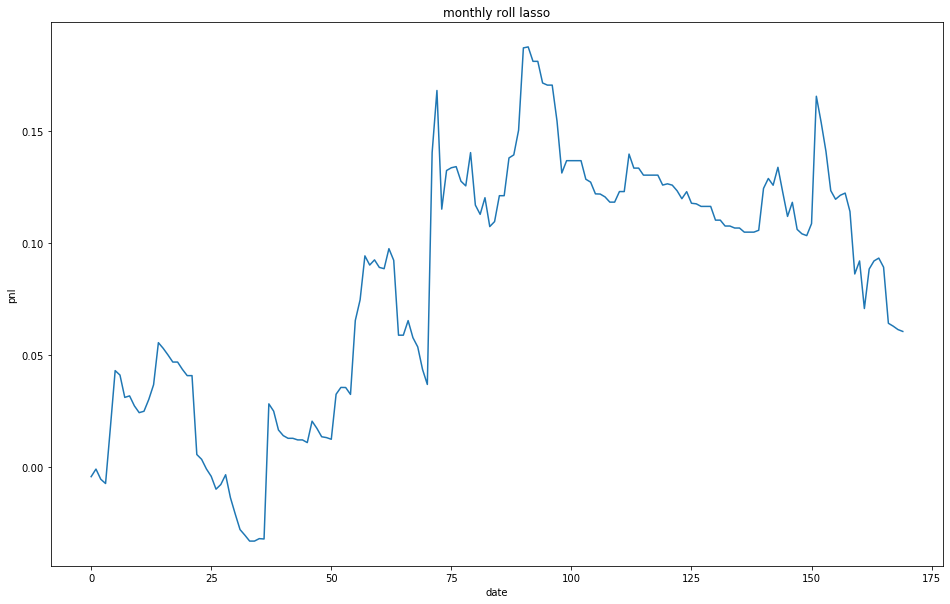

In [57]:
n_product = len(product_list[0:2])
save_path = "signal result atr"
#strat = "universal.lasso.4096"
#strat = "rolling.lasso.4096"
strat = "roll.crypto.lasso.4096"
start_month = 0
min_pnl = 4
min_num = 20
end_month = sum(month_len[0] <= "2019-08")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    #train_mat = np.zeros((train_end-train_start+1, n_product))
    #test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        if i_product==0:
            train_mat = np.zeros((len(train_pnl), n_product))
            test_mat = np.zeros((len(test_pnl), n_product))
        train_mat[:,i_product] = train_pnl
        
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    avg_test_pnl = test_mat.mean(axis=1)
    #avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #print(len(avg_test_pnl_mean)==len(avg_test_pnl))
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    #print(all_pnl)
    #print(len(all_pnl), len(avg_test_pnl))
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

# sharpe  0.3797287331752823




- we can see that the result is not so good but acceptable

- Congratulations! You have finished this course!
- Thank you very much for your participation! I wish you would enjoy taking this course!
- Happy trading in the future!